# $N\to \Delta$ Aluminum Asymmetry Calculation (Relativistic Fermi Gas)
***

Sources: 
* P. Amore et al., Nuc. Phys. A 690 509-534 (2001)
* L. Alvarez-Ruso et al., Phys. Lett. B 497 214-220 (2001)
* J.E. Amaro et al., Nuc. Phys. A 657 161-186 (1999)
* T.W. Donnelly et al., Foundations of Nuclear and Particle Physics, Cambridge Press, (Sections 16.2-16.4)

## Table of Contents
1. [Preamble](#Preamble)
1. [Function Definitions](#Function-Definitions)
    1. [Constants](#Constants:)
    1. [Kinematic Variable Functions](#Kinematic-Variable-Functions:)
    1. [Form Factor Parameterizations](#Form-Factor-Parameterizations:)
    1. [W Functions](#W-Functions:)
    1. [Scaling Functions](#Scaling-Functions:)
    1. [D Functions](#D-Functions:)
    1. [U Functions](#U-Functions:)
    1. [Response Functions](#Response-Functions:)
    1. [Width Integration](#Width-Integration:)
    1. [Asymmetry](#Asymmetry:)
1. [Plotting](#Plotting)

## Preamble
Return:[TOC](#Table-of-Contents)

In [1]:
# Load packages and modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
# For debug
#from IPython.core.debugger import set_trace

In [2]:
# Set ploting related commands
%matplotlib inline
plt.style.use('seaborn-ticks')

## Function Definitions
Return:[TOC](#Table-of-Contents)

### Constants:
Return:[TOC](#Table-of-Contents)

In [3]:
m_N = 938.0 #[MeV] Nucleon mass (proton)
m_pi = 139.57 #[MeV] Pion mass
m_delta = 1232.0 #[MeV] Breit-Wigner Delta Mass
w_delta = 120.0 #[MeV] Breit-Wigner Delta Width
k_f = 220.0 #[MeV] Fermi Momentum (236 MeV for Al, source: Donnelly book)
E_f = np.sqrt(k_f*k_f+m_N*m_N) #[MeV] Fermi Energy?????
eta_f = k_f/m_N
epsilon_f = np.sqrt(1.0+np.square(eta_f))
xi_f = epsilon_f-1.0
sinthw = 0.23
beta_0 = -2.0*sinthw
beta_1 = 1.0-2.0*sinthw
alpha = 1.0/137.035999139
G_F = 1.1663787e-5

### Kinematic Variable Functions:
Return:[TOC](#Table-of-Contents)

In [4]:
def Kappa(q):
    return np.divide(q, 2.0*m_N)

def Lambda(w):
    return np.divide(w, 2.0*m_N)

def mu(W):
    return np.divide(W, m_N)

def Tau(q, w):
    return np.square(Kappa(q)) - np.square(Lambda(w))

def Rho(W, q, w):
    return (1.0+np.divide(np.square(mu(W))-1.0, 4.0*Tau(q, w)))

def W_invar(q, w):
    return np.sqrt(np.square(m_N + w) - np.square(q))

### Form Factor Parameterizations:
Return:[TOC](#Table-of-Contents)

In [5]:
def delta_dipole(q, w):
    l_dipole = 1.0
    return np.divide(1.0, np.sqrt(1.0+l_dipole*Tau(q, w)))
    
def f_dipole(q, w, c_dipole=4.97):
    return np.divide(1.0, np.square(1.0 + c_dipole*Tau(q, w)))

def G_E_PC(q, w):
    g_E_PC = -0.03
    return g_E_PC*f_dipole(q, w)*delta_dipole(q, w)

def G_M_PC(q, w):
    g_M_PC = 2.97
    return g_M_PC*f_dipole(q, w)*delta_dipole(q, w)

def G_C_PC(q, w):
    g_C_PC = -0.44
    return g_C_PC*f_dipole(q, w)*delta_dipole(q, w)

def G_E_PV(q, w):
    return beta_1*G_E_PC(q, w)

def G_M_PV(q, w):
    return beta_1*G_M_PC(q, w)

def G_C_PV(q, w):
    return beta_1*G_C_PC(q, w)

def G_E_A(q, w):
    g_E_A = 2.22
    c_E_A = 3.53
    return g_E_A*f_dipole(q, w, c_dipole=c_E_A)

def G_M_A(q, w):
    g_M_A = 0.0
    c_M_A = 3.53
    return g_M_A*f_dipole(q, w, c_dipole=c_M_A)

### W Functions:
Return:[TOC](#Table-of-Contents)

In [6]:
def w_1_PC(W, q, w):
    t1 = 3.0*np.square(G_E_PC(q, w))
    t2 = np.square(G_M_PC(q, w))
    return (1.0/16.0)*(t1+t2)*np.square(mu(W)+1.0)*(np.square(mu(W)-1.0)+4.0*Tau(q, w))

def w_2_PC(W, q, w):
    t1 = 3.0*np.square(G_E_PC(q, w))
    t2 = np.square(G_M_PC(q, w))
    t3 = np.divide(4.0*Tau(q, w), mu(W)*mu(W))*np.square(G_C_PC(q, w))
    t0 = (1.0/16.0)*np.divide(4.0*Tau(q,w) + np.square(mu(W) - 1.0), 1.0 + Tau(q, w)*np.square(Rho(W, q, w)))
    return t0*np.square(mu(W) + 1.0)*(t1+t2+t3)

def w_1_PV(W, q, w):
    t1 = 3.0*G_E_PC(q, w)*G_E_PV(q, w)
    t2 = G_M_PC(q, w)*G_M_PV(q, w)
    return (1.0/16.0)*(t1+t2)*np.square(mu(W)+1.0)*(np.square(mu(W)-1.0)+4.0*Tau(q, w))

def w_2_PV(W, q, w):
    t1 = 3.0*G_E_PC(q, w)*G_E_PV(q, w)
    t2 = G_M_PC(q, w)*G_M_PV(q, w)
    t3 = np.divide(4.0*Tau(q, w), mu(W)*mu(W))*G_C_PC(q, w)*G_C_PV(q, w)
    t0 = (1.0/16.0)*np.divide(4.0*Tau(q,w) + np.square(mu(W) - 1.0), 1.0 + Tau(q, w)*np.square(Rho(W, q, w)))
    return t0*np.square(mu(W) + 1.0)*(t1+t2+t3)

def w_3_PV(W, q, w):
    t1 = 3.0*G_E_PC(q, w)*G_M_A(q, w)
    t2 = G_E_A(q, w)*G_M_PC(q, w)
    return (1.0/4.0)*(np.square(mu(W))-1.0)*(t1+t2)

### Scaling Functions:
Return:[TOC](#Table-of-Contents)

In [7]:
def Lambda_0(W, q, w):
    t1 = np.sqrt(1.0 + 4.0*np.square(Kappa(q))*Rho(W, q, w))
    return (1.0/2.0)*(t1-1.0)

def Lambda_0_mod(W, q, w):
    '''Source: Donnelly book'''
    t1 = np.sqrt(np.square(mu(W)) + 4.0*np.square(Kappa(q)))
    return (1.0/2.0)*(t1-1.0)

def Psi(W, q, w):
    t1 = Kappa(q)*np.sqrt(np.divide(1.0, Tau(q, w))+np.square(Rho(W, q, w)))
    t2 = -1.0*Lambda(w)*Rho(W, q, w)-1.0
    if (Lambda(w) >= Lambda_0_mod(W, q, w)):
        return np.sqrt((1.0/xi_f)*(t1+t2))
    elif (Lambda(w) < Lambda_0_mod(W, q, w)):
        return -1.0*np.sqrt((1.0/xi_f)*(t1+t2))
    else:
        return 0.0
        #print('Returning NaN')
        #return float('nan')

### D Functions:
Return:[TOC](#Table-of-Contents)

In [8]:
def D_L(W, q, w):
    t1 = np.square(Lambda(w)*Rho(W, q, w) + 1.0)
    t2 = (Lambda(w)*Rho(W, q, w) + 1.0)*(1.0 + np.square(Psi(W, q, w)))*xi_f
    t3 = (1.0/3.0)*(1.0 + np.square(Psi(W, q, w)) + np.square(np.square(Psi(W, q, w))))*xi_f*xi_f
    return np.divide(Tau(q, w), np.square(Kappa(q)))*(t1+t2+t3)-(1.0 + Tau(q, w)*np.square(Rho(W, q, w)))

def D_T(W, q, w):
    return D_L(W, q, w)

def D_Tp(W, q, w):
    t1 = np.divide(1.0, Kappa(q))*np.sqrt(np.divide(Tau(q, w), 1.0 + Tau(q, w)*np.square(Rho(W, q, w))))
    t2 = 1.0 + Lambda(w)*Rho(W, q, w)  + xi_f*(1.0 + np.square(Psi(W, q, w)))
    return t1*t2 - 1.0

### U Functions:
Return:[TOC](#Table-of-Contents)

In [9]:
def U_L_PC(W, q, w):
    t1 = (1.0 + Tau(q, w)*np.square(Rho(W, q, w)))*w_2_PC(W, q, w)
    t2 = -1.0*w_1_PC(W, q, w)
    t3 = w_2_PC(W, q, w)*D_L(W, q, w)
    return np.divide(np.square(Kappa(q)), Tau(q, w))*(t1+t2+t3)

def U_T_PC(W, q, w):
    return 2.0*w_1_PC(W, q, w) + w_2_PC(W, q, w)*D_T(W, q, w)

def U_L_PV(W, q, w):
    t1 = (1.0 + Tau(q, w)*np.square(Rho(W, q, w)))*w_2_PV(W, q, w)
    t2 = -1.0*w_1_PV(W, q, w)
    t3 = w_2_PV(W, q, w)*D_L(W, q, w)
    return np.divide(np.square(Kappa(q)), Tau(q, w))*(t1+t2+t3)

def U_T_PV(W, q, w):
    return 2.0*w_1_PV(W, q, w) + w_2_PV(W, q, w)*D_T(W, q, w)

def U_Tp_PV(W, q, w):
    t1 = 2.0*np.sqrt(Tau(q, w)*(1.0 + Tau(q, w)*np.square(Rho(W, q, w))))*w_3_PV(W, q, w)
    t2 = 1.0 + D_Tp(W, q, w)
    return t1*t2

### Response Functions:
Return:[TOC](#Table-of-Contents)

In [10]:
def C(q, w, A):
    return np.divide(3.0*A, 4.0*m_N*Kappa(q)*eta_f*eta_f*eta_f)
    
def heaviside(x):
    return 0.5*(np.sign(x) + 1.0)

def R_L_PC(W, q, w, A):
    return C(q, w, A)*xi_f*(1.0 - np.square(Psi(W, q, w)))*U_L_PC(W, q, w)*heaviside(1.0-np.square(Psi(W, q, w)))

def R_T_PC(W, q, w, A):
    return C(q, w, A)*xi_f*(1.0 - np.square(Psi(W, q, w)))*U_T_PC(W, q, w)*heaviside(1.0-np.square(Psi(W, q, w)))

def R_L_PV(W, q, w, A):
    return C(q, w, A)*xi_f*(1.0 - np.square(Psi(W, q, w)))*U_L_PV(W, q, w)*heaviside(1.0-np.square(Psi(W, q, w)))

def R_T_PV(W, q, w, A):
    return C(q, w, A)*xi_f*(1.0 - np.square(Psi(W, q, w)))*U_T_PV(W, q, w)*heaviside(1.0-np.square(Psi(W, q, w)))

def R_Tp_PV(W, q, w, A):
    return C(q, w, A)*xi_f*(1.0 - np.square(Psi(W, q, w)))*U_Tp_PV(W, q, w)*heaviside(1.0-np.square(Psi(W, q, w)))

### Width Integration:
Return:[TOC](#Table-of-Contents)

In [11]:
W_min = m_N + m_pi

def W_max(q, w):
    return np.sqrt(np.square(E_f + w) - np.square(q - k_f))

def p_pi(W):
    t1 = np.divide(np.square(np.square(W) - m_N*m_N - m_pi*m_pi), 4.0)
    t2 = -1.0*m_N*m_N*m_pi*m_pi
    return np.divide(1.0, W)*np.sqrt(t1 + t2)

def Gamma(W):
    return w_delta*np.divide(m_delta, W)*np.power(np.divide(p_pi(W), p_pi(m_delta)), 3.0)

def Weighting(W):
    nt1 = np.divide(Gamma(W), 2.0)
    dt1 = np.square(W - m_delta)
    dt2 = np.divide(np.square(Gamma(W)), 4.0)
    return (1.0/np.pi)*np.divide(nt1, dt1 + dt2)

In [12]:
def wR_L_PC(W, q, w, A):
    return Weighting(W)*R_L_PC(W, q, w, A)

def wR_T_PC(W, q, w, A):
    return Weighting(W)*R_T_PC(W, q, w, A)

def wR_L_PV(W, q, w, A):
    return Weighting(W)*R_L_PV(W, q, w, A)

def wR_T_PV(W, q, w, A):
    return Weighting(W)*R_T_PV(W, q, w, A)

def wR_Tp_PV(W, q, w, A):
    return Weighting(W)*R_Tp_PV(W, q, w, A)

In [13]:
def R_L_PC_int(q, w, A):
    if (W_min >= W_max(q, w)):
        val = 0.0
    elif (W_min < W_max(q, w)):
        val, err = quad(wR_L_PC, W_min, W_max(q, w), args=(q, w, A))
    return val

def R_T_PC_int(q, w, A):
    if (W_min >= W_max(q, w)):
        val = 0.0
    elif (W_min < W_max(q, w)):
        val, err = quad(wR_T_PC, W_min, W_max(q, w), args=(q, w, A))
    return val

def R_L_PV_int(q, w, A):
    if (W_min >= W_max(q, w)):
        val = 0.0
    elif (W_min < W_max(q, w)):
        val, err = quad(wR_L_PV, W_min, W_max(q, w), args=(q, w, A))
    return val

def R_T_PV_int(q, w, A):
    if (W_min >= W_max(q, w)):
        val = 0.0
    elif (W_min < W_max(q, w)):
        val, err = quad(wR_T_PV, W_min, W_max(q, w), args=(q, w, A))
    return val

def R_Tp_PV_int(q, w, A):
    if (W_min >= W_max(q, w)):
        val = 0.0
    elif (W_min < W_max(q, w)):
        val, err = quad(wR_Tp_PV, W_min, W_max(q, w), args=(q, w, A))
    return val

### Asymmetry:
Return:[TOC](#Table-of-Contents)

In [35]:
def v_L(q, w):
    return np.square(np.divide(Tau(q,w), np.square(Kappa(q))))

def v_T(q, w, th):
    t1 = (1.0/2.0)*np.divide(Tau(q,w), np.square(Kappa(q)))
    t2 = np.square(np.tan(np.divide(np.deg2rad(th), 2.0)))
    return t1+t2

def v_Tp(q, w, th):
    t1 = np.tan(np.divide(np.deg2rad(th), 2.0))
    t2 = np.divide(Tau(q,w), np.square(Kappa(q)))
    t3 = np.square(np.tan(np.divide(np.deg2rad(th), 2.0)))
    return t1*np.sqrt(t2 + t3)

def A_0(q, w):
    return np.divide(G_F*m_N*m_N, np.pi*alpha*np.sqrt(2.0))*Tau(q, w)

In [31]:
def Asym(q, w, A, th):
    t1 = v_Tp(q, w, th)*R_Tp_PV_int(q, w, A)
    t2 = v_L(q, w)*R_L_PC_int(q, w, A) + v_T(q, w, th)*R_T_PC_int(q, w, A)
    return A_0(q, w)*(-1.0*beta_1+np.divide(t1, t2))

def AsymRatio(q, w, A, th):
    return np.divide(Asym(q, w, A, th), A_0(q, w))

## Plotting
Return:[TOC](#Table-of-Contents)

In [16]:
w_range = np.arange(0.0, 810.0, 10.0)
w_asym_range = np.arange(368.0, 968.0, 10.0)

In [17]:
w_range

array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
       110., 120., 130., 140., 150., 160., 170., 180., 190., 200., 210.,
       220., 230., 240., 250., 260., 270., 280., 290., 300., 310., 320.,
       330., 340., 350., 360., 370., 380., 390., 400., 410., 420., 430.,
       440., 450., 460., 470., 480., 490., 500., 510., 520., 530., 540.,
       550., 560., 570., 580., 590., 600., 610., 620., 630., 640., 650.,
       660., 670., 680., 690., 700., 710., 720., 730., 740., 750., 760.,
       770., 780., 790., 800.])

In [18]:
w_asym_range

array([368., 378., 388., 398., 408., 418., 428., 438., 448., 458., 468.,
       478., 488., 498., 508., 518., 528., 538., 548., 558., 568., 578.,
       588., 598., 608., 618., 628., 638., 648., 658., 668., 678., 688.,
       698., 708., 718., 728., 738., 748., 758., 768., 778., 788., 798.,
       808., 818., 828., 838., 848., 858., 868., 878., 888., 898., 908.,
       918., 928., 938., 948., 958.])

In [19]:
# No delta width
dat_R_L_PC = np.array([R_L_PC(m_delta, 1000.0, i, 12.0) for i in w_range])
dat_R_T_PC = np.array([R_T_PC(m_delta, 1000.0, i, 12.0) for i in w_range])
dat_R_L_PV = np.array([R_L_PV(m_delta, 1000.0, i, 12.0) for i in w_range])
dat_R_T_PV = np.array([R_T_PV(m_delta, 1000.0, i, 12.0) for i in w_range])
dat_R_Tp_PV = np.array([R_Tp_PV(m_delta, 1000.0, i, 12.0) for i in w_range])

In [20]:
# Energy dependent width
dat_R_L_PC_int = np.array([R_L_PC_int(1000.0, i, 12.0) for i in w_range])
dat_R_T_PC_int = np.array([R_T_PC_int(1000.0, i, 12.0) for i in w_range])
dat_R_L_PV_int = np.array([R_L_PV_int(1000.0, i, 12.0) for i in w_range])
dat_R_T_PV_int = np.array([R_T_PV_int(1000.0, i, 12.0) for i in w_range])
dat_R_Tp_PV_int = np.array([R_Tp_PV_int(1000.0, i, 12.0) for i in w_range])

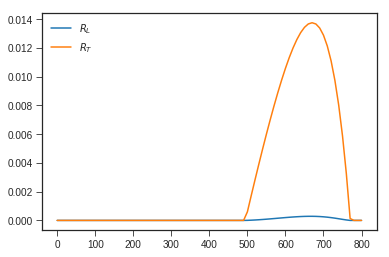

In [21]:
plt.figure()
plt.plot(w_range, dat_R_L_PC, label='$R_{L}$')
plt.plot(w_range, dat_R_T_PC, label='$R_{T}$')
plt.legend(loc='upper left')
plt.show()

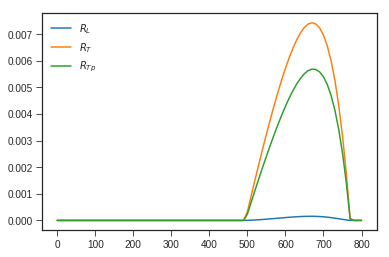

In [22]:
plt.figure()
plt.plot(w_range, dat_R_L_PV, label='$R_{L}$')
plt.plot(w_range, dat_R_T_PV, label='$R_{T}$')
plt.plot(w_range, dat_R_Tp_PV, label='$R_{Tp}$')
plt.legend(loc='upper left')
plt.show()

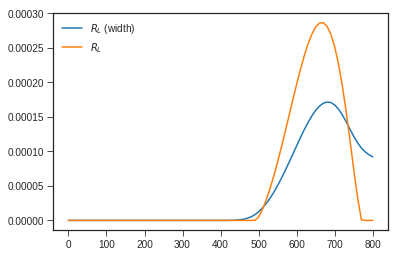

In [23]:
plt.figure()
plt.plot(w_range, dat_R_L_PC_int, label='$R_{L}$ (width)')
plt.plot(w_range, dat_R_L_PC, label='$R_{L}$')
plt.legend(loc='upper left')
plt.show()

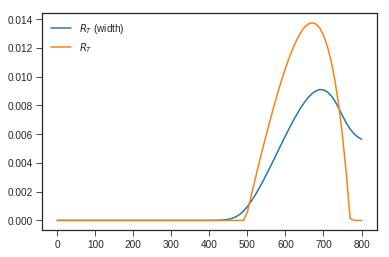

In [24]:
plt.figure()
plt.plot(w_range, dat_R_T_PC_int, label='$R_{T}$ (width)')
plt.plot(w_range, dat_R_T_PC, label='$R_{T}$')
plt.legend(loc='upper left')
plt.show()

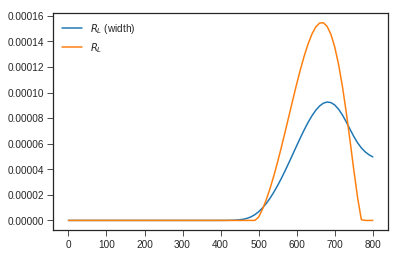

In [25]:
plt.figure()
plt.plot(w_range, dat_R_L_PV_int, label='$R_{L}$ (width)')
plt.plot(w_range, dat_R_L_PV, label='$R_{L}$')
plt.legend(loc='upper left')
plt.show()

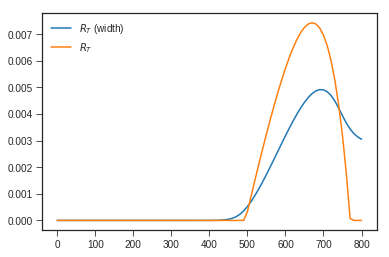

In [26]:
plt.figure()
plt.plot(w_range, dat_R_T_PV_int, label='$R_{T}$ (width)')
plt.plot(w_range, dat_R_T_PV, label='$R_{T}$')
plt.legend(loc='upper left')
plt.show()

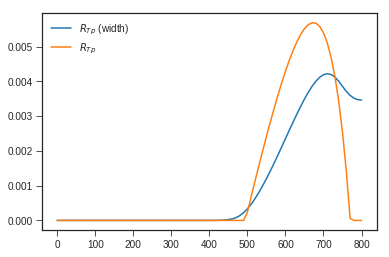

In [27]:
plt.figure()
plt.plot(w_range, dat_R_Tp_PV_int, label='$R_{Tp}$ (width)')
plt.plot(w_range, dat_R_Tp_PV, label='$R_{Tp}$')
plt.legend(loc='upper left')
plt.show()

In [32]:
asym = np.array([AsymRatio(1000.0, i, 12.0, 10.0) for i in w_asym_range])

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]


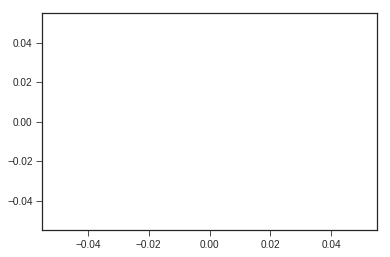

In [33]:
plt.figure()
plt.plot(w_asym_range, asym)
plt.show()